Deliverables



1. A report (in the form of a presentation, both verbal and through a slides)


2. A github repository containing your jupyter notebook that walks through the pipeline along with the .py files necessary to reproduce your model.



In [66]:
import wrangle
import pandas as pd
import numpy as np
import evaluate
import explore
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, explained_variance_score
from scipy import stats

In [2]:
#use wrangle.py to import data from mySQL
df =wrangle.get_data_from_sql()

In [3]:
# check DF head
df.head()

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date
0,2.0,3.0,1458.0,6037.0,8284.0,1.0,97318.0,1970.0,34686163.0,-118113100.0,136104.0,2319.90,2017-06-23
1,1.0,2.0,1421.0,6037.0,6707.0,NaN,96018.0,1911.0,33999877.0,-118291863.0,35606.0,543.69,2017-06-30
2,3.0,4.0,2541.0,6059.0,4975.0,NaN,96958.0,2003.0,33694636.0,-117912245.0,880456.0,9819.72,2017-06-01
3,2.0,3.0,1650.0,6037.0,7300.0,NaN,96037.0,1949.0,33985377.0,-118361620.0,614000.0,7673.19,2017-06-01
4,1.0,2.0,693.0,6037.0,2908.0,NaN,96023.0,1921.0,34112946.0,-118208106.0,274237.0,3267.47,2017-06-29


In [4]:
# check DF tail
df.tail()

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date
14985,3.0,5.0,2526.0,6059.0,7800.0,1.0,97018.0,1994.0,33753643.0,-117766503.0,458903.0,5718.72,2017-06-30
14986,3.0,5.0,2735.0,6059.0,7100.0,1.0,97067.0,1963.0,33783173.0,-117817799.0,115387.0,1465.88,2017-06-30
14987,2.0,3.0,1536.0,6037.0,8818.0,1.0,96523.0,1955.0,34058178.0,-117948180.0,297097.0,3519.78,2017-06-30
14988,3.0,5.0,2655.0,6059.0,6000.0,NaN,97065.0,1994.0,33836898.0,-117801369.0,746963.0,8065.50,2017-06-30
14989,3.0,4.0,2305.0,6037.0,5742.0,NaN,96129.0,1949.0,33952368.0,-118441155.0,579047.0,6996.21,2017-06-30


In [5]:
# there are null values in lot_size, pool, zip_code, year_built and tax-value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14990 entries, 0 to 14989
Data columns (total 13 columns):
bathrooms           14990 non-null float64
bedrooms            14990 non-null float64
square_feet         14990 non-null float64
fips                14990 non-null float64
lot_size            14893 non-null float64
pool                3287 non-null float64
zip_code            14982 non-null float64
year_built          14974 non-null float64
latitude            14990 non-null float64
longitude           14990 non-null float64
assessed_value      14990 non-null float64
tax_value           14989 non-null float64
transaction_date    14990 non-null object
dtypes: float64(12), object(1)
memory usage: 1.5+ MB


In [6]:
#wrangle data to remove NANs
df = wrangle.wrangle_zillow()

In [7]:
#create a new column tax-rate
df['tax_rate'] = df.tax_value/df.assessed_value

In [9]:
df.head(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date,tax_rate
0,2.0,3.0,1458.0,6037,8284,1,97318,1970,34686163.0,-118113100.0,136104.0,2319.90,2017-06-23,0.017045
1,1.0,2.0,1421.0,6037,6707,0,96018,1911,33999877.0,-118291863.0,35606.0,543.69,2017-06-30,0.015270


In [10]:
#https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697
#source for county fips code. Read codes in a data DataFrame named fips_codes
#fips_codes = pd.read_clipboard()

In [11]:
fips_code = pd.DataFrame({
    'fips': [6037, 6059, 6111],
    'County':['Los Angles', 'Orange', 'Ventura']
})
fips_code.head()

,fips,County
0,6037,Los Angles
1,6059,Orange
2,6111,Ventura


In [12]:
#merge df and fips_codes 
df = pd.merge(df, fips_code, left_on='fips', right_on='fips', how='left')

In [13]:
df.head(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date,tax_rate,County
0,2.0,3.0,1458.0,6037,8284,1,97318,1970,34686163.0,-118113100.0,136104.0,2319.90,2017-06-23,0.017045,Los Angles
1,1.0,2.0,1421.0,6037,6707,0,96018,1911,33999877.0,-118291863.0,35606.0,543.69,2017-06-30,0.015270,Los Angles


In [14]:
#split the data into train and test
train, test = train_test_split(df, train_size = .70, random_state = 123)

# Data Exploration (Using train data only)

In [15]:
#create a subset of df with continuous variables to create pairplot
train_plot = df[['bathrooms', 'bedrooms', 'square_feet', 'lot_size', 'assessed_value']]

In [16]:
train_plot.head(2)

,bathrooms,bedrooms,square_feet,lot_size,assessed_value
0,2.0,3.0,1458.0,8284,136104.0
1,1.0,2.0,1421.0,6707,35606.0


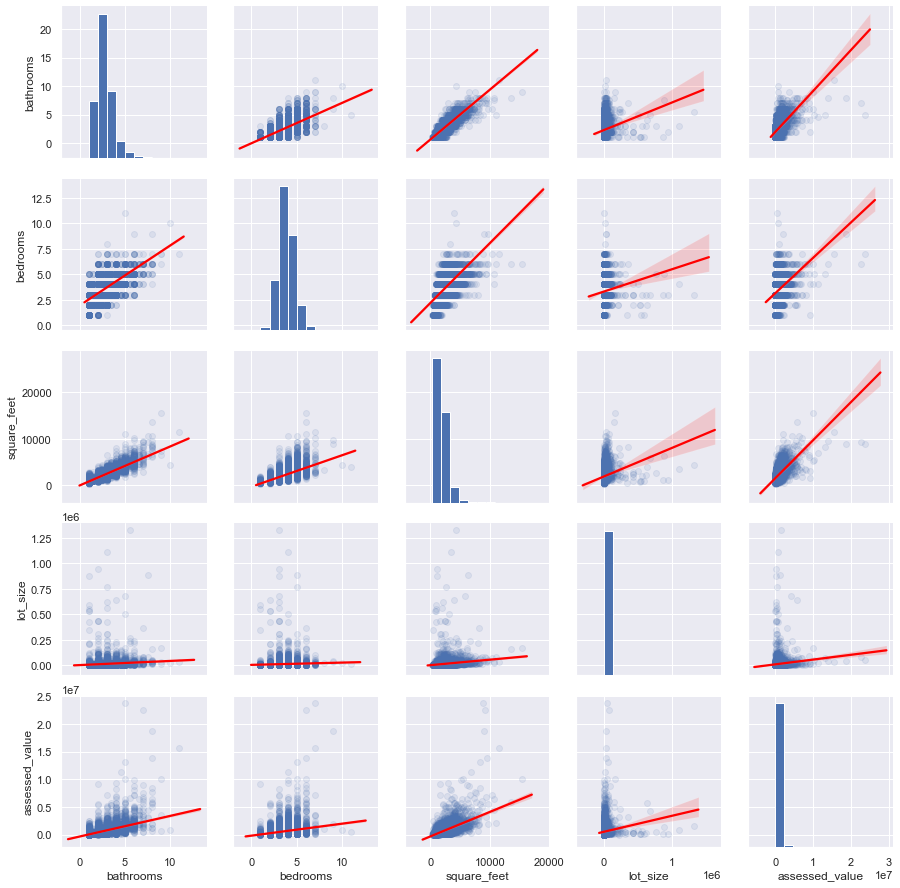

In [17]:
explore.plot_variable_pairs(train_plot)

# Home value seems to be correlated to number of bathrooms, bedrooms, square_feet and lot size

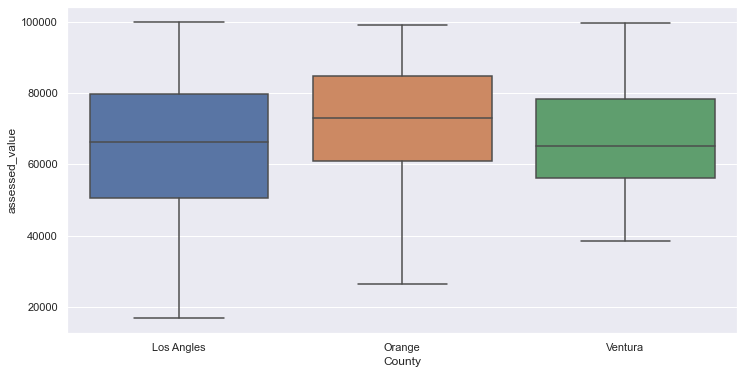

In [18]:
# Lets look at box plot of home values in each county. For better visualization, homes above 1 million are not plotted
plt.figure(figsize=(12,6))
sns.boxplot(x= train[train.assessed_value<100000].County, y= train[train.assessed_value<100000].assessed_value, data=train[train.assessed_value<100000])

In [19]:
train.head()

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date,tax_rate,County
1969,2.0,3.0,1793.0,6037,10032,1,96469,1956,34112268.0,-117736579.0,471862.0,5805.08,2017-05-09,0.012302,Los Angles
11174,1.0,1.0,768.0,6059,1320,1,96181,1964,33890131.0,-117990185.0,233507.0,2828.78,2017-06-19,0.012114,Orange
7468,2.0,3.0,1480.0,6037,7013,0,96161,1955,33857952.0,-118360292.0,98324.0,1310.38,2017-06-01,0.013327,Los Angles
6287,1.0,3.0,1073.0,6037,6328,0,96173,1951,33954504.0,-118032119.0,286277.0,3781.14,2017-05-26,0.013208,Los Angles
11360,1.0,3.0,1188.0,6037,5302,0,96212,1946,33863931.0,-118142447.0,70158.0,1133.55,2017-06-20,0.016157,Los Angles


In [20]:
# median value of homes is a better measure of central tendency for home values due to outliers.
train[train.assessed_value <1000000].assessed_value.median()

341639.5

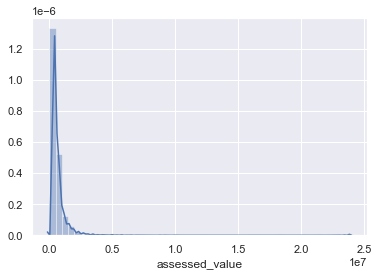

In [21]:
# plot showing distribution of home values. This looks like right skewed distribution
sns.distplot(train.assessed_value)

In [22]:
cm = train_plot.corr()
cm

,bathrooms,bedrooms,square_feet,lot_size,assessed_value
bathrooms,1.000000,0.643196,0.855253,0.140262,0.516795
bedrooms,0.643196,1.000000,0.630065,0.069576,0.273758
square_feet,0.855253,0.630065,1.000000,0.182419,0.602603
lot_size,0.140262,0.069576,0.182419,1.000000,0.116572
assessed_value,0.516795,0.273758,0.602603,0.116572,1.000000


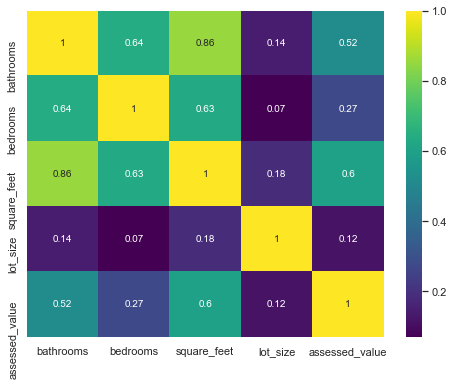

In [23]:
# lets look at heatmap and corresponding correlation values 
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='viridis')

# $H_0$: there is no relationship between home values and number of bedrooms, bathrooms and square_feet
# $H_a$: There is a relationship between home values and number of bedrooms, bathrooms and square_feet

In [24]:
#Lets take a look at simple model based on bathoom, bedroom and squarefeet and compare if against the baseline(median home value)
X_train = train[['bedrooms', 'bathrooms', 'square_feet']]
y_train = train[['assessed_value']]
y_train['y_baseline'] = train['assessed_value'].median()

In [25]:
y_train.head()

,assessed_value,y_baseline
1969,471862.0,385793.0
11174,233507.0,385793.0
7468,98324.0,385793.0
6287,286277.0,385793.0
11360,70158.0,385793.0


In [26]:
# Calculating the baseline (based on median) RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_bl = sqrt(mean_squared_error(y_train.assessed_value, y_train.y_baseline))

rmse_bl

748179.0533946215

In [27]:
#We now create a OLS model based on bedrooms, bathrooms and square_feet
from statsmodels.formula.api import ols

# generate parameters, i.e. create model
ols_model = ols('assessed_value ~ bedrooms + bathrooms + square_feet', data = train).fit()

# compute predictions and add to original dataframe
y_train['yhat'] = ols_model.predict(X_train)

In [28]:
y_train.head()

,assessed_value,y_baseline,yhat
1969,471862.0,385793.0,497410.978137
11174,233507.0,385793.0,253096.157967
7468,98324.0,385793.0,345580.392571
6287,286277.0,385793.0,101369.746675
11360,70158.0,385793.0,157154.147123


In [29]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         assessed_value   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     2091.
Date:                Wed, 08 Apr 2020   Prob (F-statistic):               0.00
Time:                        12:14:19   Log-Likelihood:            -1.5290e+05
No. Observations:               10411   AIC:                         3.058e+05
Df Residuals:                   10407   BIC:                         3.058e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.639e+04   2.13e+04     -0.768      0.442   -5.82e+04    2.54e+04
bedrooms    -1.498e+05   8136.680    -18.415      0.000   -1.66e+05   -1.34e+05
bathrooms    4.678e+04   1.12e+04      4.186      0.000    2.49e+04    6.87e+04
square_feet   485.0817     11.217     43.243      0.000     463.093     507.070
==============================================================================
Omnibus:                    18304.948   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         47841459.329
Skew:                          12.134   Prob(JB):                         0.00
Kurtosis:                     334.206   Cond. No.                     8.59e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Since my p-value is <0.05, I can reject my null hypothesis.
# This means that there is statistically significant relationship between home prices and  independent variables used above.

In [30]:

rmse = sqrt(mean_squared_error(y_train.assessed_value, y_train.yhat))
rmse

578329.7713362346

#  RMSE for OLS model with bedrooom, bathroom and square feet (578329) is lower than the baseline (based on median)748179.  R2 is 0.37 and p-value is 0.

# I am next going to build a simple linear regression model based on bathrooms, bedrooms and square feet

In [43]:
# make a dataframe 'predictions' with actual home values
predictions = pd.DataFrame({
    'actual': y_train.assessed_value
})
predictions.head()

,actual
1969,471862.000
11174,233507.000
7468,98324.000
6287,286277.000
11360,70158.000


In [32]:
X_train1 = X_train[['bedrooms', 'bathrooms', 'square_feet']]
y_train1 = y_train[['assessed_value']]

In [33]:
#linear regression model
lm = LinearRegression()

In [34]:
# fit our train data on the model
lm.fit(X_train1, y_train1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [35]:
print("Linear Model:", lm)

print("intercept: ", lm.intercept_)

print("coefficients: ", lm.coef_)

Linear Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
intercept:  [-16390.82570268]
coefficients:  [[-149838.17145678   46782.37648537     485.08174302]]


In [44]:
#predictions from linear regresssion model based on X_train independent variable values
predictions['yhat_lm'] = lm.predict(X_train1)

In [45]:
#Baseline predicted home value (median home price)
predictions['baseline'] = y_train.assessed_value.median()

In [46]:
predictions.head(2)

,actual,yhat_lm,baseline
1969,471862.000,497410.978,385793.000
11174,233507.000,253096.158,385793.000


In [48]:
# Use lamda and calculate RMSE for each columns in prediction dataframe
pd.options.display.float_format = '{:.3f}'.format
predictions.apply(lambda col: sqrt(mean_squared_error(predictions.actual, col)))

actual          0.000
yhat_lm    578329.771
baseline   748179.053
dtype: float64

# The RMSE above for the linear model is better than baseline

# Lets use this model on test data and see how well it does there

In [49]:
#using test data and predicting home values based on linear model above
X_test = test[['bedrooms', 'bathrooms', 'square_feet']]
y_test = test[['assessed_value']]
y_test['test_prediction'] = lm.predict(X_test)

In [53]:
y_test.rename(columns = {'assessed_value': 'actual'}, inplace = True)

In [54]:
y_test.head(2)

,actual,test_prediction
5884,127320.000,668159.752
1583,576498.000,304992.878


In [42]:
#Calculating RMSE for test predictions
y_test.apply(lambda col: sqrt(mean_squared_error(y_test.assessed_value, col)))

assessed_value         0.000
test_prediction   559911.039
dtype: float64

# The RMSE for test data is lower than the train data!! This linear means model is working well (atleast better than baseline)

# We will know try to explore this data more and do feature engineering to see if we can do better than the model above

Seems like most of the data is from LA county followed by Orange and then Ventura county

Text(0.5, 0, 'County')

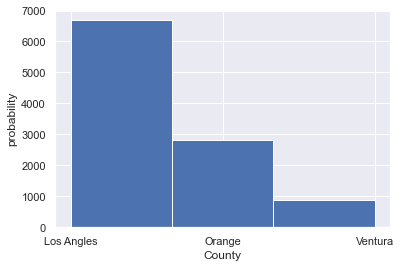

In [122]:
plt.hist(train.County, density=False, bins=3)
plt.ylabel('probability')
plt.xlabel('County')

Text(0.5, 0, 'Number of bathrooms')

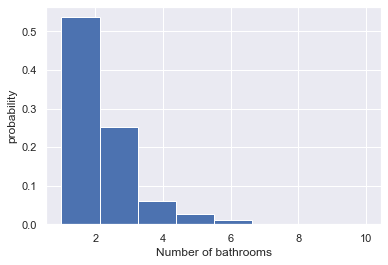

In [123]:
plt.hist(train.bathrooms, density=True, bins=8)  # `density=False` would make counts
plt.ylabel('probability')
plt.xlabel('Number of bathrooms')


Text(0.5, 0, 'Number of bedrooms')

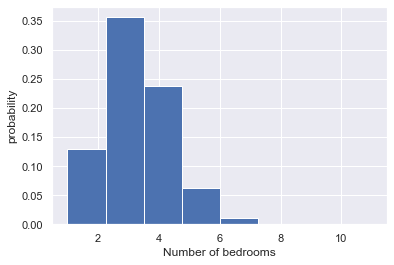

In [124]:
plt.hist(train.bedrooms, density=True, bins=8)  # `density=False` would make counts
plt.ylabel('probability')
plt.xlabel('Number of bedrooms')



Text(0.5, 0, 'Year built')

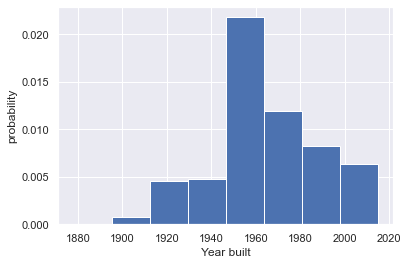

In [125]:
plt.hist(train.year_built, density=True, bins=8)  # `density=False` would make counts
plt.ylabel('probability')
plt.xlabel('Year built')

Text(0.5, 0, 'Square Feet')

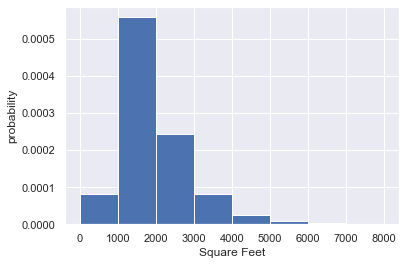

In [126]:
plt.hist(train.square_feet, density=True, bins=[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000])  # `density=False` would make counts
plt.ylabel('probability')
plt.xlabel('Square Feet')

Text(0.5, 0, 'tax_rate')

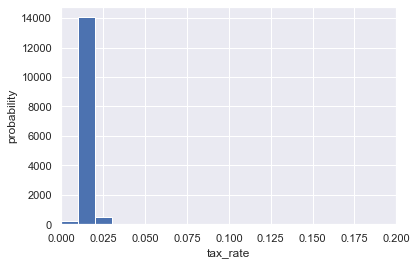

In [93]:
plt.hist(df.tax_rate, density=False, bins=[0, 0.01, 0.02, 0.03, 0.04, 0.05])  # `density=False` would make counts
plt.ylabel('probability')
plt.xlim(0,0.2)
plt.xlabel('tax_rate')

(0.0, 0.04)

<Figure size 864x432 with 0 Axes>

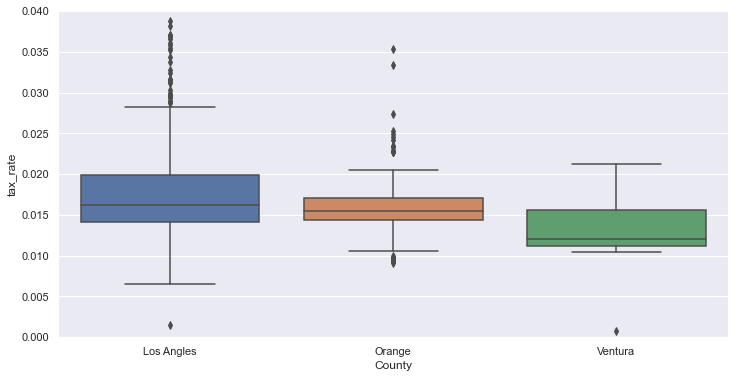

In [100]:
plt.figure(figsize=(12,6))
plt.figure(figsize=(12,6))
sns.boxplot(x= train[train.assessed_value<100000].County, y= train[train.assessed_value<100000].tax_rate, data=train[train.assessed_value<100000])
plt.ylim(0,0.04)

# It seems like tax rate (average) is higher compared to Orange and Ventura counties

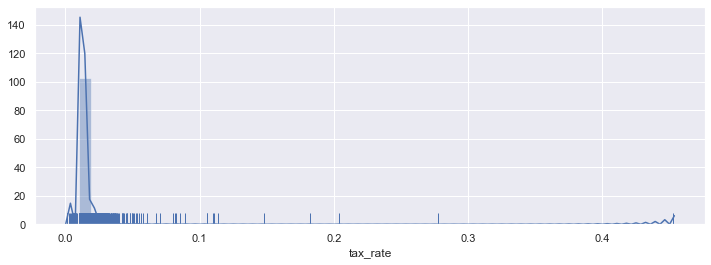

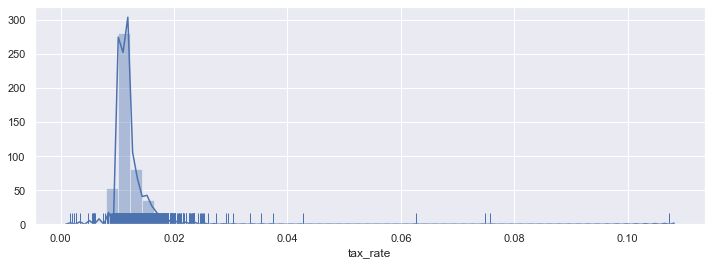

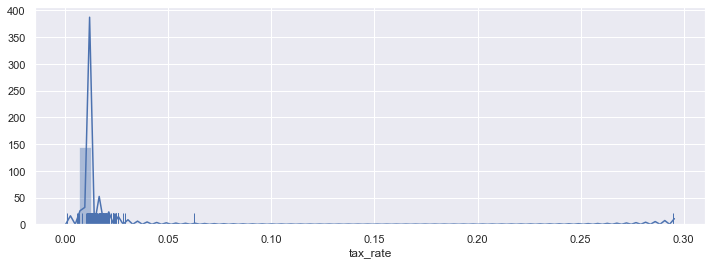

In [132]:
plt.figure(figsize=(12,4))
# below are plots for tax_rate distributions in three counties
sns.distplot(df[df.County == 'Los Angles'].tax_rate, rug=True)
plt.show()
plt.figure(figsize=(12,4))
sns.distplot(df[df.County == 'Orange'].tax_rate, rug=True)
plt.show()
plt.figure(figsize=(12,4))
sns.distplot(df[df.County == 'Ventura'].tax_rate, rug=True)

# Lets see if we can add new features to our model. We start by exploring other variables and their correlation with home values. We will use train data for this exploration

In [116]:
train_plot2 = train[['assessed_value','bedrooms', 'bathrooms', 'square_feet', 'lot_size', 'year_built']]

In [117]:
cm = train_plot2.corr()
cm

,assessed_value,bedrooms,bathrooms,square_feet,lot_size,year_built
assessed_value,1.000,0.267,0.508,0.596,0.137,0.172
bedrooms,0.267,1.000,0.644,0.628,0.076,0.394
bathrooms,0.508,0.644,1.000,0.856,0.171,0.535
square_feet,0.596,0.628,0.856,1.000,0.210,0.464
lot_size,0.137,0.076,0.171,0.210,1.000,0.078
year_built,0.172,0.394,0.535,0.464,0.078,1.000


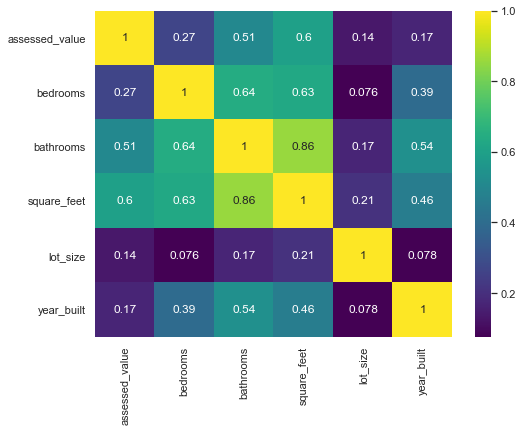

In [118]:
# lets look at heatmap and corresponding correlation values 
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='viridis')

The heatmap suggests some correlation between lot_size,year_built and home value too.

The histograms above for bedroom, bathroom and square_feet are right skewed. We can possibly tranform the data using log scale to make them more 'normal'

In [ ]:
sns.distplot(train., rug=True)